## Imports ##

In [1]:
import torch
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.autograd import Variable
from torch import optim
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import math
import copy

from torchvision.models import resnet50, ResNet50_Weights

torch.manual_seed(0)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

## Model ##

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LeNet(nn.Module):
    def __init__(self, max_growth):
        super(LeNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc1 = nn.Linear(400,500+max_growth)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(500+max_growth,100+max_growth)
        self.relu1 = nn.ReLU()
        self.fc3 = nn.Linear(100+max_growth,10)

        #Custom Functionality
        self.max_growth = max_growth
        previous_module = self.parameters_to_prune()[0][0]

        for module, name in self.parameters_to_prune()[1:]:

          #Prune incoming weights (Previous layers outgoing weights)
          if previous_module != None:
            mask = torch.ones(np.shape(previous_module.weight))
            mask[-max_growth:,:] = 0
            prune.custom_from_mask(previous_module, name, mask)
            
          #Prune outgoing weights
          mask = torch.ones(np.shape(module.weight))
          mask[:,-max_growth:] = 0
          prune.custom_from_mask(module, name, mask)

          previous_module = module  #save layer for next iteration
        

    def parameters_to_prune(self):
        return ((self.fc1, 'weight'),
                (self.fc2, 'weight'),
                (self.fc3, 'weight'),) 
    #End Custom Functionality

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu1(out)
        out = self.fc3(out)
        return out

## Data ##

In [3]:
# Define relevant variables for the ML task
batch_size = 64
num_classes = 10
learning_rate = 0.001

#Loading the dataset and preprocessing
train_dataset = torchvision.datasets.MNIST(root = '/Users/dimademler/Desktop/me-Programming/pytorch',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)


test_dataset = torchvision.datasets.MNIST(root = '/Users/dimademler/Desktop/me-Programming/pytorch',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

augmented_train_dataset = torchvision.datasets.MNIST(root = '/Users/dimademler/Desktop/me-Programming/pytorch',
                                           train = True,
                                           transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomVerticalFlip(p=1),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1307,), std = (0.3081,))]),
                                           download = True)

augmented_train_loader = torch.utils.data.DataLoader(dataset = augmented_train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

augmented_test_dataset = torchvision.datasets.MNIST(root = '/Users/dimademler/Desktop/me-Programming/pytorch',
                                          train = False,
                                          transform = transforms.Compose([
                                                  transforms.Resize((32,32)),
                                                  transforms.RandomVerticalFlip(p=1),
                                                  transforms.ToTensor(),
                                                  transforms.Normalize(mean = (0.1325,), std = (0.3105,))]),
                                          download=True)


augmented_test_loader = torch.utils.data.DataLoader(dataset = augmented_test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

#Setting the loss function
cost = nn.CrossEntropyLoss()

#this is defined to print how many steps are remaining when training
total_step = len(train_loader)

def train(model,train_loader,test_loader,num_epochs,optimizer):
  total_step = len(train_loader)
  for epoch in range(num_epochs):
      for i, (images, labels) in enumerate(train_loader):  
          images = images.to(device)
          labels = labels.to(device)
          
          #Forward pass
          outputs = model(images)
          loss = cost(outputs, labels)
            
          # Backward and optimize
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
              
          if (i+1) % 400 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
  
def test(model, test_loader):
    # Test the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(test_loader):  
            test_output = model(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

    print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    return accuracy

          
              

## Methods ##

In [4]:
#All in One Method to Find Lottery Tickets given a model and dataset, saves models in shared drive
def find_ticket(model, name, train_loader, test_loader, start_iter = 0, end_iter = 30, num_epochs = 10, learning_rate = .001, prune_amount = .2, k = 3):
  
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  #If training has already been saved
  try:
    model.load_state_dict(torch.load('/Users/dimademler/Desktop/me-Programming/pytorch/Adaptive_ML/models_1/'+ name + '_RewindWeights' + '_' + str(k)))
  except:
    train(model, train_loader,test_loader,num_epochs = k, optimizer = optimizer)  #Save Kth epoch model
    torch.save(model.state_dict(), '/Users/dimademler/Desktop/me-Programming/pytorch/Adaptive_ML/models_1/' + name + '_RewindWeights' + '_' + str(k))

  model_rewind = LeNet(max_growth = model.max_growth) #Save as separate model so we can rewind our weights back to this
  model_rewind.load_state_dict(torch.load('/Users/dimademler/Desktop/me-Programming/pytorch/Adaptive_ML/models_1/'+ name + '_RewindWeights' + '_' + str(k)))

  train(model, train_loader,test_loader,num_epochs = num_epochs - k, optimizer = optimizer) #Finish off training
  accuracy = []

  for i in range(start_iter, end_iter): 
    #Prune
    prune.global_unstructured(model.parameters_to_prune(),pruning_method=prune.L1Unstructured,amount=prune_amount,)
    
    #Rewind Weights
    for idx, (module, _) in enumerate(model.parameters_to_prune()):
      with torch.no_grad():
        module_rewind = model_rewind.parameters_to_prune()[idx][0]
        module.weight_orig.copy_(module_rewind.weight)

    print(
    "Global Sparsity: {:.2f}%".format(
        100. * (float(torch.sum(model.fc3.weight == 0)) + float(torch.sum(model.fc1.weight == 0)) + float(torch.sum(model.fc2.weight == 0)))
        / (float(model.fc3.weight.nelement()) + float(model.fc1.weight.nelement()) + float(model.fc2.weight.nelement()))
    )
    )
    
    #Train
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train(model, train_loader,test_loader,num_epochs = num_epochs, optimizer = optimizer)
    accuracy.append(test(model, test_loader))

    plt.plot(np.arange(len(accuracy)), accuracy)
    plt.show()
    print('Saving iteration ', str(i+1))
    torch.save(model.state_dict(), '/Users/dimademler/Desktop/me-Programming/pytorch/Adaptive_ML/models_1/' + name + '_iter' + str(i+1)) 

def grow(model, parameters_to_prune, amount):
  previous_module = parameters_to_prune[0][0]

  for module, name in parameters_to_prune[1:]:
    mask = module.get_buffer('weight_mask').data
    #Pick Suitable Locations
    omega = []
    for idx, val in enumerate(torch.sum(mask, dim = 0)): 
      if val == 0:
        omega.append(idx)

    indices = np.random.choice(omega, size = min(len(omega), amount), replace = False)
    
    #Grow at these indices
    module.get_buffer('weight_mask')[:,indices] = 1
    prune.custom_from_mask(module,'weight', torch.ones(module.weight.size()))

    previous_module.get_buffer('weight_mask')[indices,:] = 1
    prune.custom_from_mask(previous_module,'weight', torch.ones(previous_module.weight.size()))  

In [7]:
def loss(model, val_loader,error_weight, structure_weight):
  error = error_weight * test(model, val_loader) #should be validation set, but for now we will use test set

  params = 0
  total_params = 0
  for module,_ in model.parameters_to_prune():
    params += float(torch.sum(module.weight == 0))
    total_params += float(module.weight.nelement())
  structure = structure_weight * params / total_params  #uses sparsity at the moment

def acceptance(current_loss, new_loss, t,d):
  p = math.exp(-1*(new_loss - current_loss) / cooling_schedule(t,d))
  return np.random.uniform() < p
    
def cooling_schedule(t,d):
  return d / math.log(t)

#returns module count - 1 long array
def sample_amount(model,t,T):
  amount = []
  prev_sparsity = float(torch.sum(model.parameters_to_prune[0][0].weight == 0)) / float(model.parameters_to_prune[0][0].weight.nelement())
  for module, _ in model.parameters_to_prune[1:]:
    sparsity = float(torch.sum(module.weight == 0)) / float(module.weight.nelement())
    amount.append(get_amount(math.exp(-1 * (prev_sparsity + sparsity + t**2 / T)**2)))
    prev_sparsity = sparsity
  return amount

#given the probability of growth, it samples to represent k-many nodes to grow
def get_amount(p):
  count = 0
  while np.random.uniform() < p: 
    if count > 100: return count #100 is just a hard cap to stop infinite loop, can be any large number
    count += 1
  return count

def simulated_annealing(model, d = 5, T = 10):
  current_model = model
  current_loss = loss(model)

  for t in range(T):
    
    amount = sample_amount(model,t,T)
    next_model = grow(model copy, amount)
    train(next_model, train_loader,test_loader,num_epochs = num_epochs, optimizer = optimizer)
    prune.global_unstructured(parameters_to_prune,pruning_method=prune.L1Unstructured,amount=prune_amount,)
    train(next_model, train_loader,test_loader,num_epochs = num_epochs, optimizer = optimizer)
    next_loss = loss(next_model)
    if acceptance(current_loss, next_loss, t, d):
      current_model = next_model
      current_loss = next_loss
      parameters_to_prune = next_parameters_to_pr   

SyntaxError: invalid syntax (692258619.py, line 43)

In [11]:
#Test Trasnferability
max_growth = 50
num_epochs = 10
model = LeNet(max_growth = max_growth)

before = []
after = []

for i in range(1,25):
  model.load_state_dict(torch.load('/Users/dimademler/Desktop/me-Programming/pytorch/Adaptive_ML/models_1/' + str(i)))
  before.append(test(model,augmented_test_loader))
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  train(model, train_loader,test_loader,num_epochs = num_epochs, optimizer = optimizer)
  after.append(test(model,augmented_test_loader))

plt.plot(np.arange(len(before), before, label = 'Before Retraining'))
plt.plot(np.arange(len(before), after, label = 'After Retraining'))
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dimademler/Desktop/me-Programming/pytorch/Adaptive_ML/models_1/1'

In [ ]:
max_growth = 50
model = LeNet(max_growth = max_growth)

parameters_to_prune = (
    (model.fc1, 'weight'),
    (model.fc2, 'weight'),
    (model.fc3, 'weight'),
)

hide_growth(parameters_to_prune, max_growth)

#model.load_state_dict(torch.load('/content/drive/MyDrive/AdaptiveML/LeNet-Ticket-15iterations'))
prune.global_unstructured(model.parameters_to_prune,pruning_method=prune.L1Unstructured,amount=.99999999)

grow(model, parameters_to_prune)

Epoch [1/7], Step [400/938], Loss: 0.0168
Epoch [1/7], Step [800/938], Loss: 0.0363
Epoch [2/7], Step [400/938], Loss: 0.0986
Epoch [2/7], Step [800/938], Loss: 0.1188
Epoch [3/7], Step [400/938], Loss: 0.0377
Epoch [3/7], Step [800/938], Loss: 0.0364
Epoch [4/7], Step [400/938], Loss: 0.0450
Epoch [4/7], Step [800/938], Loss: 0.0022
Epoch [5/7], Step [400/938], Loss: 0.0151
Epoch [5/7], Step [800/938], Loss: 0.0013
Epoch [6/7], Step [400/938], Loss: 0.1308
Epoch [6/7], Step [800/938], Loss: 0.0058
Epoch [7/7], Step [400/938], Loss: 0.0332
Epoch [7/7], Step [800/938], Loss: 0.0001
Global Sparsity: 33.95%
Epoch [1/10], Step [400/938], Loss: 0.0280
Epoch [1/10], Step [800/938], Loss: 0.0118
Epoch [2/10], Step [400/938], Loss: 0.0173
Epoch [2/10], Step [800/938], Loss: 0.0049
Epoch [3/10], Step [400/938], Loss: 0.0140
Epoch [3/10], Step [800/938], Loss: 0.0039
Epoch [4/10], Step [400/938], Loss: 0.0035
Epoch [4/10], Step [800/938], Loss: 0.0676
Epoch [5/10], Step [400/938], Loss: 0.0315
E

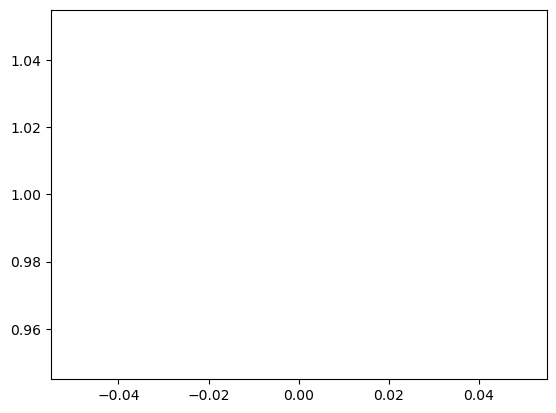

Saving iteration  1
Global Sparsity: 47.16%
Epoch [1/10], Step [400/938], Loss: 0.0895
Epoch [1/10], Step [800/938], Loss: 0.0341
Epoch [2/10], Step [400/938], Loss: 0.0158
Epoch [2/10], Step [800/938], Loss: 0.0241
Epoch [3/10], Step [400/938], Loss: 0.1124
Epoch [3/10], Step [800/938], Loss: 0.0873
Epoch [4/10], Step [400/938], Loss: 0.0067
Epoch [4/10], Step [800/938], Loss: 0.0186
Epoch [5/10], Step [400/938], Loss: 0.0013
Epoch [5/10], Step [800/938], Loss: 0.0047
Epoch [6/10], Step [400/938], Loss: 0.0310
Epoch [6/10], Step [800/938], Loss: 0.0033
Epoch [7/10], Step [400/938], Loss: 0.0007
Epoch [7/10], Step [800/938], Loss: 0.0057
Epoch [8/10], Step [400/938], Loss: 0.0001
Epoch [8/10], Step [800/938], Loss: 0.0001
Epoch [9/10], Step [400/938], Loss: 0.0001
Epoch [9/10], Step [800/938], Loss: 0.0049
Epoch [10/10], Step [400/938], Loss: 0.0317
Epoch [10/10], Step [800/938], Loss: 0.0043
Test Accuracy of the model on the 10000 test images: 1.00


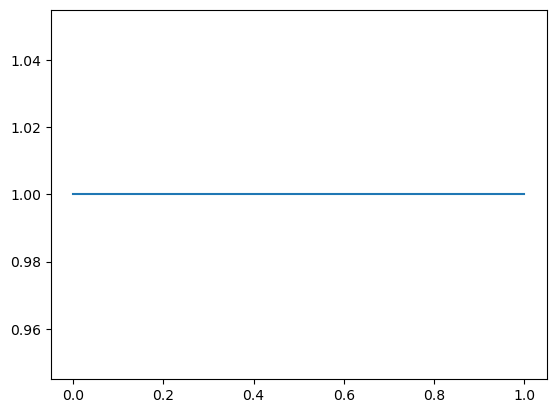

Saving iteration  2
Global Sparsity: 57.73%
Epoch [1/10], Step [400/938], Loss: 0.1634
Epoch [1/10], Step [800/938], Loss: 0.0048
Epoch [2/10], Step [400/938], Loss: 0.0021
Epoch [2/10], Step [800/938], Loss: 0.0020
Epoch [3/10], Step [400/938], Loss: 0.0012
Epoch [3/10], Step [800/938], Loss: 0.0003
Epoch [4/10], Step [400/938], Loss: 0.0008
Epoch [4/10], Step [800/938], Loss: 0.0543
Epoch [5/10], Step [400/938], Loss: 0.2430
Epoch [5/10], Step [800/938], Loss: 0.0116
Epoch [6/10], Step [400/938], Loss: 0.0016
Epoch [6/10], Step [800/938], Loss: 0.0118
Epoch [7/10], Step [400/938], Loss: 0.0010
Epoch [7/10], Step [800/938], Loss: 0.0004
Epoch [8/10], Step [400/938], Loss: 0.0006
Epoch [8/10], Step [800/938], Loss: 0.0036
Epoch [9/10], Step [400/938], Loss: 0.0013
Epoch [9/10], Step [800/938], Loss: 0.0181
Epoch [10/10], Step [400/938], Loss: 0.0002
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


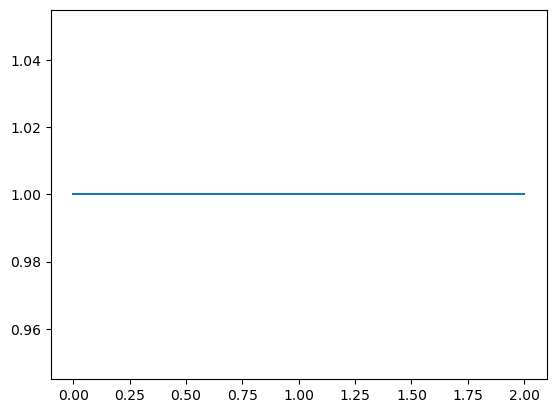

Saving iteration  3
Global Sparsity: 66.18%
Epoch [1/10], Step [400/938], Loss: 0.0697
Epoch [1/10], Step [800/938], Loss: 0.0112
Epoch [2/10], Step [400/938], Loss: 0.0206
Epoch [2/10], Step [800/938], Loss: 0.0096
Epoch [3/10], Step [400/938], Loss: 0.0007
Epoch [3/10], Step [800/938], Loss: 0.0023
Epoch [4/10], Step [400/938], Loss: 0.1241
Epoch [4/10], Step [800/938], Loss: 0.0005
Epoch [5/10], Step [400/938], Loss: 0.0000
Epoch [5/10], Step [800/938], Loss: 0.0002
Epoch [6/10], Step [400/938], Loss: 0.0010
Epoch [6/10], Step [800/938], Loss: 0.0000
Epoch [7/10], Step [400/938], Loss: 0.0000
Epoch [7/10], Step [800/938], Loss: 0.0147
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0043
Epoch [9/10], Step [400/938], Loss: 0.0010
Epoch [9/10], Step [800/938], Loss: 0.0001
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


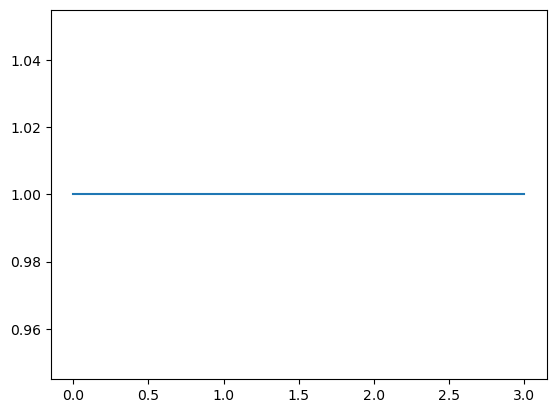

Saving iteration  4
Global Sparsity: 72.94%
Epoch [1/10], Step [400/938], Loss: 0.0033
Epoch [1/10], Step [800/938], Loss: 0.0091
Epoch [2/10], Step [400/938], Loss: 0.0003
Epoch [2/10], Step [800/938], Loss: 0.0008
Epoch [3/10], Step [400/938], Loss: 0.0001
Epoch [3/10], Step [800/938], Loss: 0.0211
Epoch [4/10], Step [400/938], Loss: 0.0000
Epoch [4/10], Step [800/938], Loss: 0.0001
Epoch [5/10], Step [400/938], Loss: 0.0098
Epoch [5/10], Step [800/938], Loss: 0.0021
Epoch [6/10], Step [400/938], Loss: 0.0006
Epoch [6/10], Step [800/938], Loss: 0.0024
Epoch [7/10], Step [400/938], Loss: 0.0003
Epoch [7/10], Step [800/938], Loss: 0.0005
Epoch [8/10], Step [400/938], Loss: 0.0001
Epoch [8/10], Step [800/938], Loss: 0.0002
Epoch [9/10], Step [400/938], Loss: 0.0008
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0001
Test Accuracy of the model on the 10000 test images: 1.00


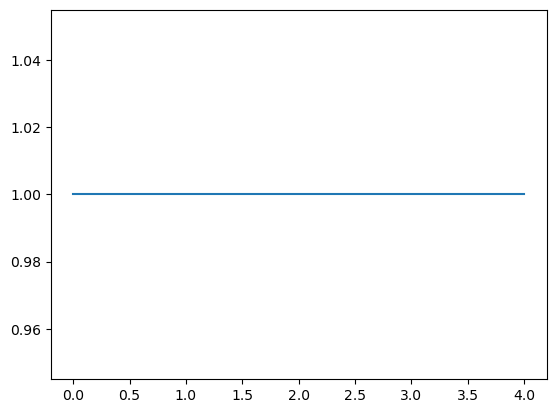

Saving iteration  5
Global Sparsity: 78.36%
Epoch [1/10], Step [400/938], Loss: 0.0220
Epoch [1/10], Step [800/938], Loss: 0.0021
Epoch [2/10], Step [400/938], Loss: 0.0018
Epoch [2/10], Step [800/938], Loss: 0.0058
Epoch [3/10], Step [400/938], Loss: 0.0825
Epoch [3/10], Step [800/938], Loss: 0.0011
Epoch [4/10], Step [400/938], Loss: 0.0003
Epoch [4/10], Step [800/938], Loss: 0.0027
Epoch [5/10], Step [400/938], Loss: 0.0078
Epoch [5/10], Step [800/938], Loss: 0.0001
Epoch [6/10], Step [400/938], Loss: 0.0001
Epoch [6/10], Step [800/938], Loss: 0.0113
Epoch [7/10], Step [400/938], Loss: 0.0001
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0001
Epoch [8/10], Step [800/938], Loss: 0.0001
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0078
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0067
Test Accuracy of the model on the 10000 test images: 1.00


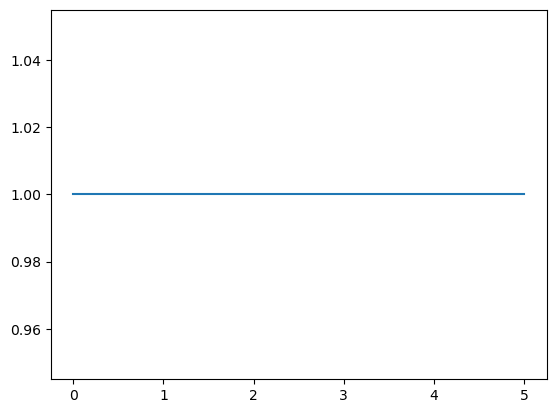

Saving iteration  6
Global Sparsity: 82.68%
Epoch [1/10], Step [400/938], Loss: 0.0073
Epoch [1/10], Step [800/938], Loss: 0.0077
Epoch [2/10], Step [400/938], Loss: 0.0002
Epoch [2/10], Step [800/938], Loss: 0.0003
Epoch [3/10], Step [400/938], Loss: 0.0000
Epoch [3/10], Step [800/938], Loss: 0.0006
Epoch [4/10], Step [400/938], Loss: 0.0011
Epoch [4/10], Step [800/938], Loss: 0.0011
Epoch [5/10], Step [400/938], Loss: 0.0144
Epoch [5/10], Step [800/938], Loss: 0.0008
Epoch [6/10], Step [400/938], Loss: 0.0002
Epoch [6/10], Step [800/938], Loss: 0.0000
Epoch [7/10], Step [400/938], Loss: 0.0000
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0085
Epoch [8/10], Step [800/938], Loss: 0.0000
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0002
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0003
Test Accuracy of the model on the 10000 test images: 0.94


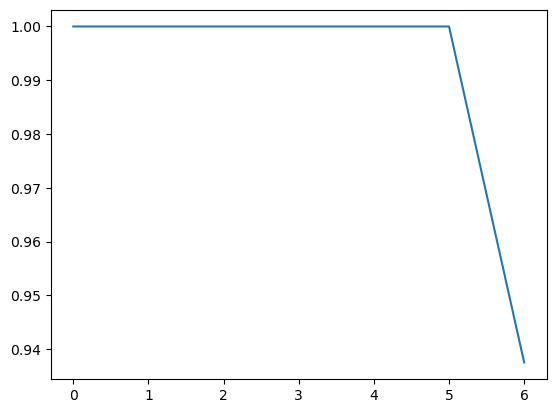

Saving iteration  7
Global Sparsity: 86.15%
Epoch [1/10], Step [400/938], Loss: 0.0028
Epoch [1/10], Step [800/938], Loss: 0.0004
Epoch [2/10], Step [400/938], Loss: 0.0008
Epoch [2/10], Step [800/938], Loss: 0.0030
Epoch [3/10], Step [400/938], Loss: 0.0000
Epoch [3/10], Step [800/938], Loss: 0.0000
Epoch [4/10], Step [400/938], Loss: 0.0001
Epoch [4/10], Step [800/938], Loss: 0.0001
Epoch [5/10], Step [400/938], Loss: 0.0001
Epoch [5/10], Step [800/938], Loss: 0.0000
Epoch [6/10], Step [400/938], Loss: 0.0624
Epoch [6/10], Step [800/938], Loss: 0.0004
Epoch [7/10], Step [400/938], Loss: 0.0062
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0000
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


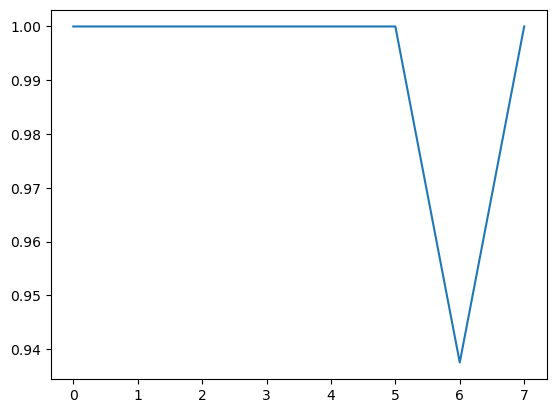

Saving iteration  8
Global Sparsity: 88.92%
Epoch [1/10], Step [400/938], Loss: 0.0030
Epoch [1/10], Step [800/938], Loss: 0.0669
Epoch [2/10], Step [400/938], Loss: 0.0006
Epoch [2/10], Step [800/938], Loss: 0.0470
Epoch [3/10], Step [400/938], Loss: 0.0044
Epoch [3/10], Step [800/938], Loss: 0.0001
Epoch [4/10], Step [400/938], Loss: 0.0023
Epoch [4/10], Step [800/938], Loss: 0.0017
Epoch [5/10], Step [400/938], Loss: 0.0001
Epoch [5/10], Step [800/938], Loss: 0.0143
Epoch [6/10], Step [400/938], Loss: 0.0000
Epoch [6/10], Step [800/938], Loss: 0.0000
Epoch [7/10], Step [400/938], Loss: 0.0003
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0000
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0001
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


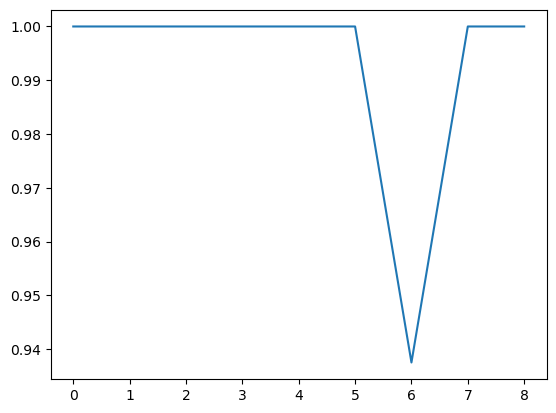

Saving iteration  9
Global Sparsity: 91.13%
Epoch [1/10], Step [400/938], Loss: 0.0044
Epoch [1/10], Step [800/938], Loss: 0.0064
Epoch [2/10], Step [400/938], Loss: 0.0002
Epoch [2/10], Step [800/938], Loss: 0.0009
Epoch [3/10], Step [400/938], Loss: 0.0034
Epoch [3/10], Step [800/938], Loss: 0.0127
Epoch [4/10], Step [400/938], Loss: 0.0000
Epoch [4/10], Step [800/938], Loss: 0.0025
Epoch [5/10], Step [400/938], Loss: 0.0001
Epoch [5/10], Step [800/938], Loss: 0.0029
Epoch [6/10], Step [400/938], Loss: 0.0003
Epoch [6/10], Step [800/938], Loss: 0.0000
Epoch [7/10], Step [400/938], Loss: 0.0000
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0004
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0002
Test Accuracy of the model on the 10000 test images: 1.00


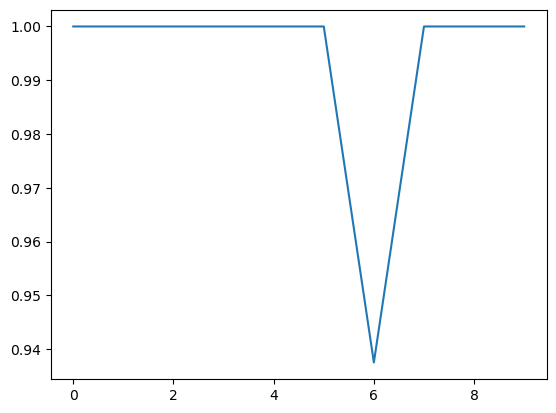

Saving iteration  10
Global Sparsity: 92.91%
Epoch [1/10], Step [400/938], Loss: 0.0164
Epoch [1/10], Step [800/938], Loss: 0.0062
Epoch [2/10], Step [400/938], Loss: 0.0051
Epoch [2/10], Step [800/938], Loss: 0.0077
Epoch [3/10], Step [400/938], Loss: 0.0008
Epoch [3/10], Step [800/938], Loss: 0.0092
Epoch [4/10], Step [400/938], Loss: 0.0000
Epoch [4/10], Step [800/938], Loss: 0.0000
Epoch [5/10], Step [400/938], Loss: 0.0009
Epoch [5/10], Step [800/938], Loss: 0.0000
Epoch [6/10], Step [400/938], Loss: 0.0000
Epoch [6/10], Step [800/938], Loss: 0.0000
Epoch [7/10], Step [400/938], Loss: 0.0002
Epoch [7/10], Step [800/938], Loss: 0.0008
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0000
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0002
Epoch [10/10], Step [400/938], Loss: 0.0001
Epoch [10/10], Step [800/938], Loss: 0.0005
Test Accuracy of the model on the 10000 test images: 0.94


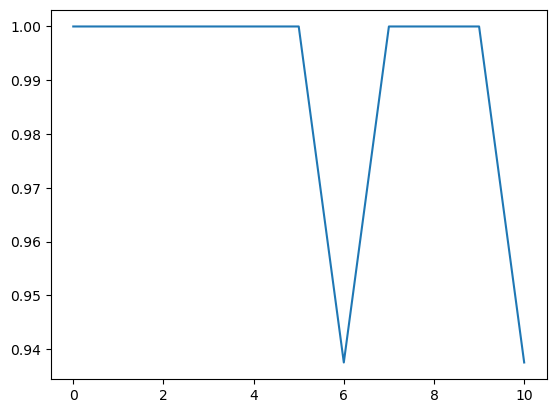

Saving iteration  11
Global Sparsity: 94.33%
Epoch [1/10], Step [400/938], Loss: 0.0131
Epoch [1/10], Step [800/938], Loss: 0.0046
Epoch [2/10], Step [400/938], Loss: 0.0018
Epoch [2/10], Step [800/938], Loss: 0.0102
Epoch [3/10], Step [400/938], Loss: 0.0009
Epoch [3/10], Step [800/938], Loss: 0.0007
Epoch [4/10], Step [400/938], Loss: 0.0001
Epoch [4/10], Step [800/938], Loss: 0.0001
Epoch [5/10], Step [400/938], Loss: 0.0000
Epoch [5/10], Step [800/938], Loss: 0.0000
Epoch [6/10], Step [400/938], Loss: 0.0016
Epoch [6/10], Step [800/938], Loss: 0.0000
Epoch [7/10], Step [400/938], Loss: 0.0000
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0001
Epoch [9/10], Step [400/938], Loss: 0.0001
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


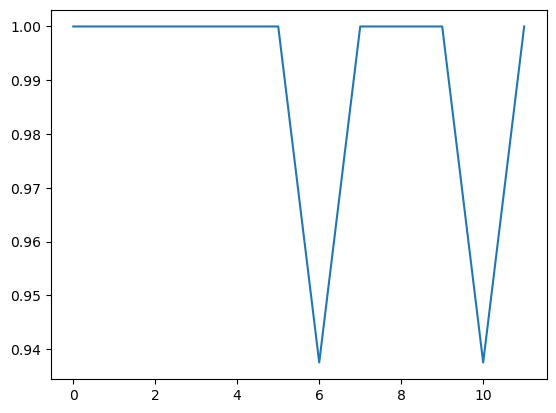

Saving iteration  12
Global Sparsity: 95.46%
Epoch [1/10], Step [400/938], Loss: 0.0022
Epoch [1/10], Step [800/938], Loss: 0.0351
Epoch [2/10], Step [400/938], Loss: 0.0021
Epoch [2/10], Step [800/938], Loss: 0.0002
Epoch [3/10], Step [400/938], Loss: 0.0004
Epoch [3/10], Step [800/938], Loss: 0.0003
Epoch [4/10], Step [400/938], Loss: 0.0001
Epoch [4/10], Step [800/938], Loss: 0.0066
Epoch [5/10], Step [400/938], Loss: 0.0002
Epoch [5/10], Step [800/938], Loss: 0.0001
Epoch [6/10], Step [400/938], Loss: 0.0002
Epoch [6/10], Step [800/938], Loss: 0.0008
Epoch [7/10], Step [400/938], Loss: 0.0000
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0001
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0001
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


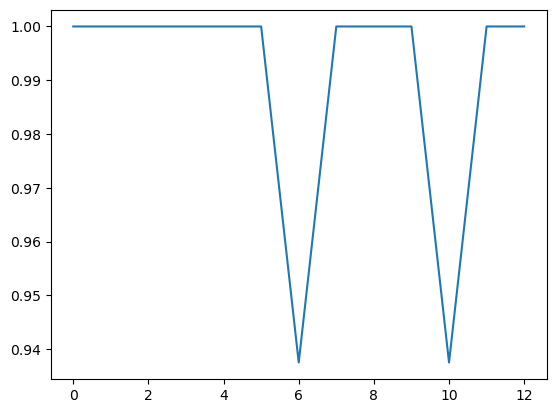

Saving iteration  13
Global Sparsity: 96.37%
Epoch [1/10], Step [400/938], Loss: 0.0166
Epoch [1/10], Step [800/938], Loss: 0.0008
Epoch [2/10], Step [400/938], Loss: 0.0015
Epoch [2/10], Step [800/938], Loss: 0.0004
Epoch [3/10], Step [400/938], Loss: 0.0004
Epoch [3/10], Step [800/938], Loss: 0.0001
Epoch [4/10], Step [400/938], Loss: 0.0001
Epoch [4/10], Step [800/938], Loss: 0.0010
Epoch [5/10], Step [400/938], Loss: 0.0014
Epoch [5/10], Step [800/938], Loss: 0.0000
Epoch [6/10], Step [400/938], Loss: 0.0000
Epoch [6/10], Step [800/938], Loss: 0.0000
Epoch [7/10], Step [400/938], Loss: 0.0000
Epoch [7/10], Step [800/938], Loss: 0.0001
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0000
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


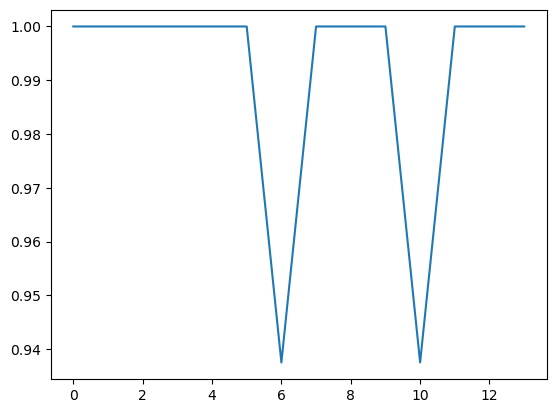

Saving iteration  14
Global Sparsity: 97.10%
Epoch [1/10], Step [400/938], Loss: 0.0036
Epoch [1/10], Step [800/938], Loss: 0.0118
Epoch [2/10], Step [400/938], Loss: 0.0048
Epoch [2/10], Step [800/938], Loss: 0.0001
Epoch [3/10], Step [400/938], Loss: 0.0004
Epoch [3/10], Step [800/938], Loss: 0.0010
Epoch [4/10], Step [400/938], Loss: 0.0009
Epoch [4/10], Step [800/938], Loss: 0.0000
Epoch [5/10], Step [400/938], Loss: 0.0000
Epoch [5/10], Step [800/938], Loss: 0.0000
Epoch [6/10], Step [400/938], Loss: 0.0090
Epoch [6/10], Step [800/938], Loss: 0.0007
Epoch [7/10], Step [400/938], Loss: 0.0001
Epoch [7/10], Step [800/938], Loss: 0.0001
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0000
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0001
Epoch [10/10], Step [400/938], Loss: 0.0002
Epoch [10/10], Step [800/938], Loss: 0.0073
Test Accuracy of the model on the 10000 test images: 1.00


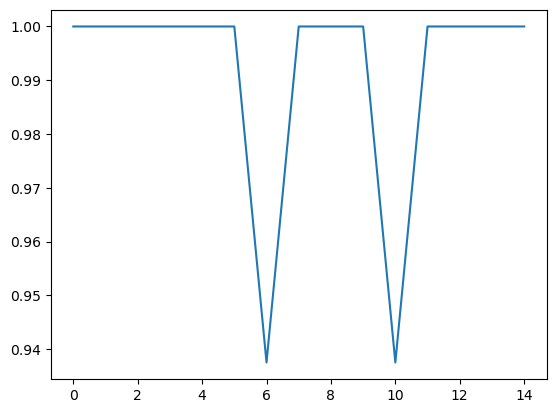

Saving iteration  15
Global Sparsity: 97.68%
Epoch [1/10], Step [400/938], Loss: 0.0058
Epoch [1/10], Step [800/938], Loss: 0.0111
Epoch [2/10], Step [400/938], Loss: 0.0026
Epoch [2/10], Step [800/938], Loss: 0.0043
Epoch [3/10], Step [400/938], Loss: 0.0000
Epoch [3/10], Step [800/938], Loss: 0.0003
Epoch [4/10], Step [400/938], Loss: 0.0085
Epoch [4/10], Step [800/938], Loss: 0.0000
Epoch [5/10], Step [400/938], Loss: 0.0008
Epoch [5/10], Step [800/938], Loss: 0.0044
Epoch [6/10], Step [400/938], Loss: 0.0002
Epoch [6/10], Step [800/938], Loss: 0.0000
Epoch [7/10], Step [400/938], Loss: 0.0069
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0008
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


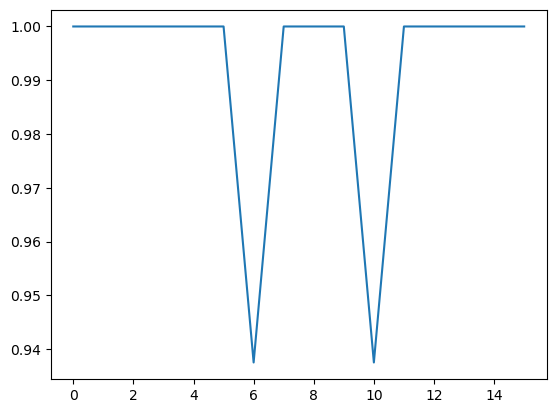

Saving iteration  16
Global Sparsity: 98.14%
Epoch [1/10], Step [400/938], Loss: 0.0034
Epoch [1/10], Step [800/938], Loss: 0.0093
Epoch [2/10], Step [400/938], Loss: 0.0137
Epoch [2/10], Step [800/938], Loss: 0.0270
Epoch [3/10], Step [400/938], Loss: 0.0014
Epoch [3/10], Step [800/938], Loss: 0.0007
Epoch [4/10], Step [400/938], Loss: 0.0000
Epoch [4/10], Step [800/938], Loss: 0.0001
Epoch [5/10], Step [400/938], Loss: 0.0011
Epoch [5/10], Step [800/938], Loss: 0.0000
Epoch [6/10], Step [400/938], Loss: 0.0000
Epoch [6/10], Step [800/938], Loss: 0.0004
Epoch [7/10], Step [400/938], Loss: 0.0002
Epoch [7/10], Step [800/938], Loss: 0.0001
Epoch [8/10], Step [400/938], Loss: 0.0004
Epoch [8/10], Step [800/938], Loss: 0.0024
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0005
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 0.94


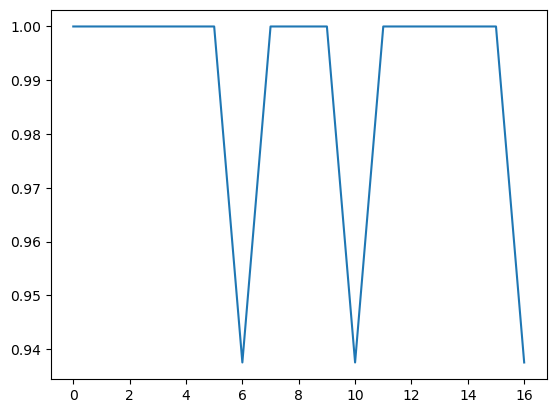

Saving iteration  17
Global Sparsity: 98.51%
Epoch [1/10], Step [400/938], Loss: 0.0111
Epoch [1/10], Step [800/938], Loss: 0.0036
Epoch [2/10], Step [400/938], Loss: 0.0508
Epoch [2/10], Step [800/938], Loss: 0.0073
Epoch [3/10], Step [400/938], Loss: 0.0004
Epoch [3/10], Step [800/938], Loss: 0.0007
Epoch [4/10], Step [400/938], Loss: 0.0001
Epoch [4/10], Step [800/938], Loss: 0.0000
Epoch [5/10], Step [400/938], Loss: 0.0020
Epoch [5/10], Step [800/938], Loss: 0.0052
Epoch [6/10], Step [400/938], Loss: 0.0004
Epoch [6/10], Step [800/938], Loss: 0.0001
Epoch [7/10], Step [400/938], Loss: 0.0019
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0000
Epoch [9/10], Step [400/938], Loss: 0.0003
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


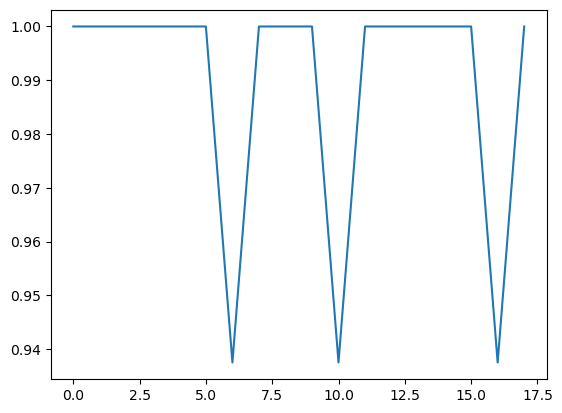

Saving iteration  18
Global Sparsity: 98.81%
Epoch [1/10], Step [400/938], Loss: 0.0169
Epoch [1/10], Step [800/938], Loss: 0.0012
Epoch [2/10], Step [400/938], Loss: 0.0004
Epoch [2/10], Step [800/938], Loss: 0.0005
Epoch [3/10], Step [400/938], Loss: 0.0097
Epoch [3/10], Step [800/938], Loss: 0.0001
Epoch [4/10], Step [400/938], Loss: 0.0000
Epoch [4/10], Step [800/938], Loss: 0.0001
Epoch [5/10], Step [400/938], Loss: 0.0003
Epoch [5/10], Step [800/938], Loss: 0.0000
Epoch [6/10], Step [400/938], Loss: 0.0002
Epoch [6/10], Step [800/938], Loss: 0.0006
Epoch [7/10], Step [400/938], Loss: 0.0002
Epoch [7/10], Step [800/938], Loss: 0.0004
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0074
Epoch [9/10], Step [400/938], Loss: 0.0125
Epoch [9/10], Step [800/938], Loss: 0.0020
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0008
Test Accuracy of the model on the 10000 test images: 1.00


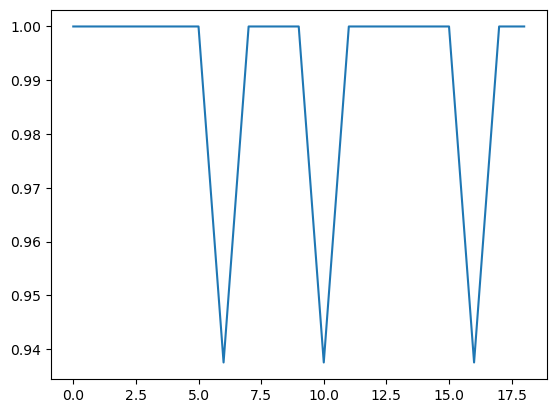

Saving iteration  19
Global Sparsity: 99.05%
Epoch [1/10], Step [400/938], Loss: 0.0609
Epoch [1/10], Step [800/938], Loss: 0.0060
Epoch [2/10], Step [400/938], Loss: 0.0024
Epoch [2/10], Step [800/938], Loss: 0.0036
Epoch [3/10], Step [400/938], Loss: 0.0038
Epoch [3/10], Step [800/938], Loss: 0.0002
Epoch [4/10], Step [400/938], Loss: 0.0009
Epoch [4/10], Step [800/938], Loss: 0.0005
Epoch [5/10], Step [400/938], Loss: 0.0002
Epoch [5/10], Step [800/938], Loss: 0.0001
Epoch [6/10], Step [400/938], Loss: 0.0000
Epoch [6/10], Step [800/938], Loss: 0.0846
Epoch [7/10], Step [400/938], Loss: 0.0011
Epoch [7/10], Step [800/938], Loss: 0.0001
Epoch [8/10], Step [400/938], Loss: 0.0039
Epoch [8/10], Step [800/938], Loss: 0.0001
Epoch [9/10], Step [400/938], Loss: 0.0000
Epoch [9/10], Step [800/938], Loss: 0.0000
Epoch [10/10], Step [400/938], Loss: 0.0015
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


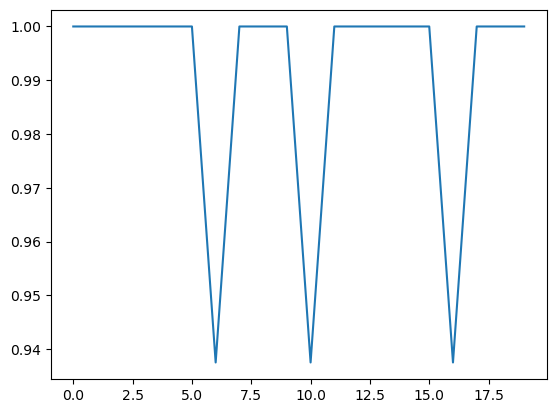

Saving iteration  20
Global Sparsity: 99.24%
Epoch [1/10], Step [400/938], Loss: 0.0062
Epoch [1/10], Step [800/938], Loss: 0.0289
Epoch [2/10], Step [400/938], Loss: 0.0769
Epoch [2/10], Step [800/938], Loss: 0.0074
Epoch [3/10], Step [400/938], Loss: 0.0137
Epoch [3/10], Step [800/938], Loss: 0.0097
Epoch [4/10], Step [400/938], Loss: 0.0006
Epoch [4/10], Step [800/938], Loss: 0.0143
Epoch [5/10], Step [400/938], Loss: 0.0023
Epoch [5/10], Step [800/938], Loss: 0.0341
Epoch [6/10], Step [400/938], Loss: 0.0001
Epoch [6/10], Step [800/938], Loss: 0.0036
Epoch [7/10], Step [400/938], Loss: 0.0001
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0000
Epoch [9/10], Step [400/938], Loss: 0.0174
Epoch [9/10], Step [800/938], Loss: 0.0009
Epoch [10/10], Step [400/938], Loss: 0.0000
Epoch [10/10], Step [800/938], Loss: 0.0044
Test Accuracy of the model on the 10000 test images: 1.00


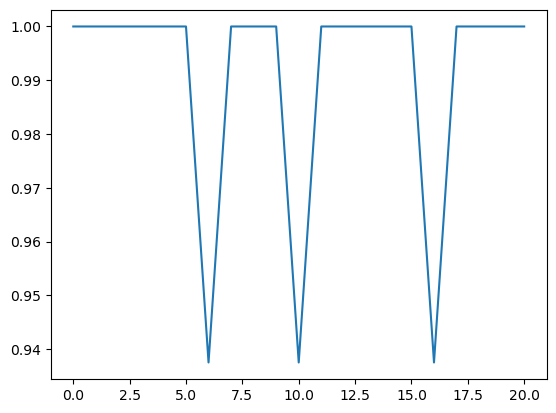

Saving iteration  21
Global Sparsity: 99.39%
Epoch [1/10], Step [400/938], Loss: 0.0052
Epoch [1/10], Step [800/938], Loss: 0.0019
Epoch [2/10], Step [400/938], Loss: 0.0146
Epoch [2/10], Step [800/938], Loss: 0.0167
Epoch [3/10], Step [400/938], Loss: 0.0012
Epoch [3/10], Step [800/938], Loss: 0.0020
Epoch [4/10], Step [400/938], Loss: 0.0065
Epoch [4/10], Step [800/938], Loss: 0.0075
Epoch [5/10], Step [400/938], Loss: 0.0267
Epoch [5/10], Step [800/938], Loss: 0.0006
Epoch [6/10], Step [400/938], Loss: 0.0004
Epoch [6/10], Step [800/938], Loss: 0.0043
Epoch [7/10], Step [400/938], Loss: 0.0105
Epoch [7/10], Step [800/938], Loss: 0.0000
Epoch [8/10], Step [400/938], Loss: 0.0000
Epoch [8/10], Step [800/938], Loss: 0.0010
Epoch [9/10], Step [400/938], Loss: 0.0173
Epoch [9/10], Step [800/938], Loss: 0.0133
Epoch [10/10], Step [400/938], Loss: 0.0013
Epoch [10/10], Step [800/938], Loss: 0.0002
Test Accuracy of the model on the 10000 test images: 1.00


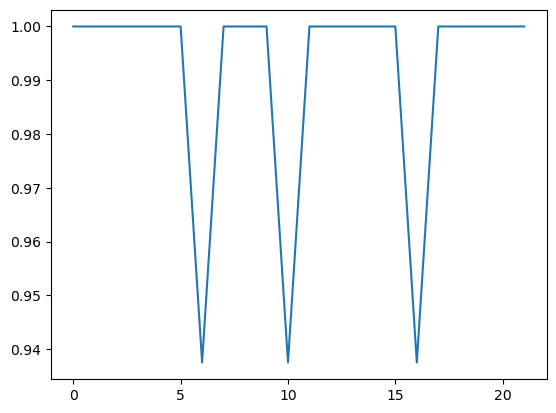

Saving iteration  22
Global Sparsity: 99.51%
Epoch [1/10], Step [400/938], Loss: 0.0022
Epoch [1/10], Step [800/938], Loss: 0.0027
Epoch [2/10], Step [400/938], Loss: 0.0045
Epoch [2/10], Step [800/938], Loss: 0.0008
Epoch [3/10], Step [400/938], Loss: 0.0330
Epoch [3/10], Step [800/938], Loss: 0.0557
Epoch [4/10], Step [400/938], Loss: 0.0416
Epoch [4/10], Step [800/938], Loss: 0.0002
Epoch [5/10], Step [400/938], Loss: 0.0001
Epoch [5/10], Step [800/938], Loss: 0.0001
Epoch [6/10], Step [400/938], Loss: 0.0114
Epoch [6/10], Step [800/938], Loss: 0.0027
Epoch [7/10], Step [400/938], Loss: 0.0089
Epoch [7/10], Step [800/938], Loss: 0.0011
Epoch [8/10], Step [400/938], Loss: 0.0002
Epoch [8/10], Step [800/938], Loss: 0.0102
Epoch [9/10], Step [400/938], Loss: 0.0224
Epoch [9/10], Step [800/938], Loss: 0.0002
Epoch [10/10], Step [400/938], Loss: 0.0798
Epoch [10/10], Step [800/938], Loss: 0.1023
Test Accuracy of the model on the 10000 test images: 0.94


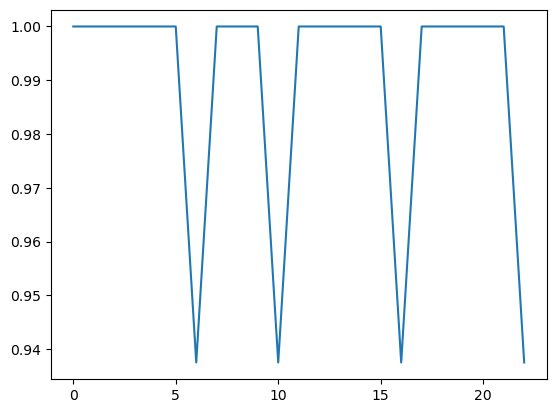

Saving iteration  23
Global Sparsity: 99.61%
Epoch [1/10], Step [400/938], Loss: 0.0267
Epoch [1/10], Step [800/938], Loss: 0.0169
Epoch [2/10], Step [400/938], Loss: 0.0125
Epoch [2/10], Step [800/938], Loss: 0.0025
Epoch [3/10], Step [400/938], Loss: 0.0360
Epoch [3/10], Step [800/938], Loss: 0.0516
Epoch [4/10], Step [400/938], Loss: 0.0267
Epoch [4/10], Step [800/938], Loss: 0.0018
Epoch [5/10], Step [400/938], Loss: 0.0015
Epoch [5/10], Step [800/938], Loss: 0.0001
Epoch [6/10], Step [400/938], Loss: 0.0020
Epoch [6/10], Step [800/938], Loss: 0.0011
Epoch [7/10], Step [400/938], Loss: 0.0015
Epoch [7/10], Step [800/938], Loss: 0.0001
Epoch [8/10], Step [400/938], Loss: 0.0359
Epoch [8/10], Step [800/938], Loss: 0.0027
Epoch [9/10], Step [400/938], Loss: 0.0003
Epoch [9/10], Step [800/938], Loss: 0.0121
Epoch [10/10], Step [400/938], Loss: 0.0021
Epoch [10/10], Step [800/938], Loss: 0.0397
Test Accuracy of the model on the 10000 test images: 1.00


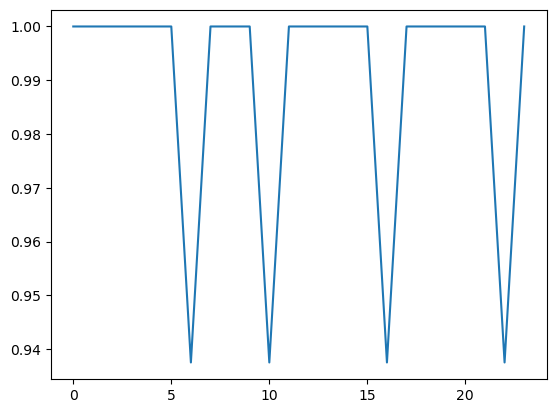

Saving iteration  24
Global Sparsity: 99.69%
Epoch [1/10], Step [400/938], Loss: 0.0082
Epoch [1/10], Step [800/938], Loss: 0.0288
Epoch [2/10], Step [400/938], Loss: 0.0175
Epoch [2/10], Step [800/938], Loss: 0.0799
Epoch [3/10], Step [400/938], Loss: 0.0214
Epoch [3/10], Step [800/938], Loss: 0.0860
Epoch [4/10], Step [400/938], Loss: 0.0139
Epoch [4/10], Step [800/938], Loss: 0.0094
Epoch [5/10], Step [400/938], Loss: 0.0027
Epoch [5/10], Step [800/938], Loss: 0.0800
Epoch [6/10], Step [400/938], Loss: 0.0018
Epoch [6/10], Step [800/938], Loss: 0.0232
Epoch [7/10], Step [400/938], Loss: 0.0059
Epoch [7/10], Step [800/938], Loss: 0.0090
Epoch [8/10], Step [400/938], Loss: 0.0006
Epoch [8/10], Step [800/938], Loss: 0.0025
Epoch [9/10], Step [400/938], Loss: 0.0004
Epoch [9/10], Step [800/938], Loss: 0.0111
Epoch [10/10], Step [400/938], Loss: 0.0025
Epoch [10/10], Step [800/938], Loss: 0.0074
Test Accuracy of the model on the 10000 test images: 1.00


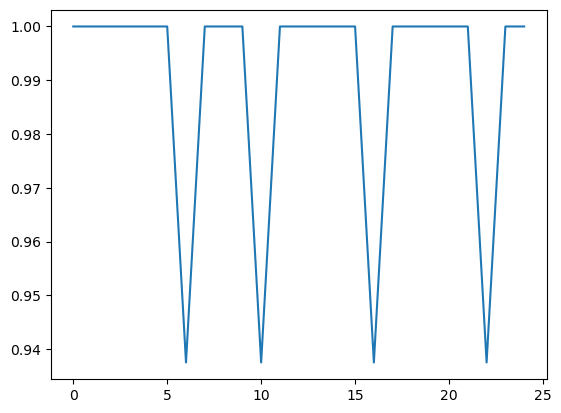

Saving iteration  25
Global Sparsity: 99.75%
Epoch [1/10], Step [400/938], Loss: 0.0348
Epoch [1/10], Step [800/938], Loss: 0.0234
Epoch [2/10], Step [400/938], Loss: 0.0860
Epoch [2/10], Step [800/938], Loss: 0.0091
Epoch [3/10], Step [400/938], Loss: 0.0022
Epoch [3/10], Step [800/938], Loss: 0.0414
Epoch [4/10], Step [400/938], Loss: 0.0049
Epoch [4/10], Step [800/938], Loss: 0.0345
Epoch [5/10], Step [400/938], Loss: 0.0015
Epoch [5/10], Step [800/938], Loss: 0.0352
Epoch [6/10], Step [400/938], Loss: 0.0548
Epoch [6/10], Step [800/938], Loss: 0.1139
Epoch [7/10], Step [400/938], Loss: 0.0594
Epoch [7/10], Step [800/938], Loss: 0.0872
Epoch [8/10], Step [400/938], Loss: 0.0225
Epoch [8/10], Step [800/938], Loss: 0.0626
Epoch [9/10], Step [400/938], Loss: 0.0163
Epoch [9/10], Step [800/938], Loss: 0.0035
Epoch [10/10], Step [400/938], Loss: 0.0001
Epoch [10/10], Step [800/938], Loss: 0.0000
Test Accuracy of the model on the 10000 test images: 1.00


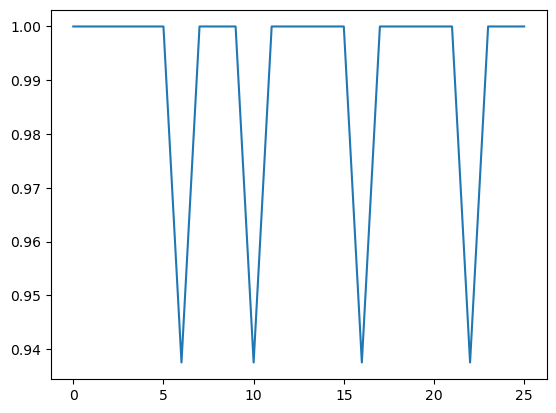

Saving iteration  26
Global Sparsity: 99.80%
Epoch [1/10], Step [400/938], Loss: 0.0410
Epoch [1/10], Step [800/938], Loss: 0.0435
Epoch [2/10], Step [400/938], Loss: 0.0355
Epoch [2/10], Step [800/938], Loss: 0.1146
Epoch [3/10], Step [400/938], Loss: 0.0982
Epoch [3/10], Step [800/938], Loss: 0.0182
Epoch [4/10], Step [400/938], Loss: 0.0591
Epoch [4/10], Step [800/938], Loss: 0.0328
Epoch [5/10], Step [400/938], Loss: 0.0016
Epoch [5/10], Step [800/938], Loss: 0.0039
Epoch [6/10], Step [400/938], Loss: 0.0105
Epoch [6/10], Step [800/938], Loss: 0.0546
Epoch [7/10], Step [400/938], Loss: 0.0129
Epoch [7/10], Step [800/938], Loss: 0.1432


KeyboardInterrupt: 

In [5]:
#Generate Tickets

max_growth = 50
model = LeNet(max_growth = max_growth)
find_ticket(model, 'MNIST', train_loader, test_loader)

#Prints

In [ ]:
print(
    "Sparsity in fc1.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc1.weight == 0))
        / float(model.fc1.weight.nelement())
    )
)
print(
    "Sparsity in fc2.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc2.weight == 0))
        / float(model.fc2.weight.nelement())
    )
)
print(
    "Sparsity in fc3.weight: {:.2f}%".format(
        100. * float(torch.sum(model.fc3.weight == 0))
        / float(model.fc3.weight.nelement())
    )
)
print(
    "Global Sparsity: {:.2f}%".format(
        100. * (float(torch.sum(model.fc3.weight == 0)) + float(torch.sum(model.fc1.weight == 0)) + float(torch.sum(model.fc2.weight == 0)))
        / (float(model.fc3.weight.nelement()) + float(model.fc1.weight.nelement()) + float(model.fc2.weight.nelement()))
    )
)

Sparsity in fc1.weight: 9.09%
Sparsity in fc2.weight: 39.39%
Sparsity in fc3.weight: 33.33%
Global Sparsity: 17.43%


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/AdaptiveML/models/MNIST_iter1'))

<All keys matched successfully>